# Mercado Livre API - Overview da API a partir de uma query
Esse notebook apresenta diferentes métricas que se pode obter ao realizar uma query à API do Mercado Libre. 

(No momento, experimentando com diferentes visualizações. Ao finalizar uma versão, a descrição dos passos será completada de acordo).

## Como usar

1. No menu superior: `Cell > Run All`
2. Digitar busca desejada no campo de texto e pressionar *Enter*
3. Aguardar alguns instantes até execução ser completada ("(Busy)" irá desaparecer do título da aba no browser)
4. Rolar para baixo e analisar os gráficos e tabelas

Para uma nova consulta, recomeçar do item 1. 

Obs.: caso a execução apresentar erros, clicar em `Kernel > Restart & Run All` no menu superior.

## Table of contents
- Resumo em lista dos itens mais vendidos 
- Visualização de quantidades vendidas, preço e estoque
- Faturamento por itens
- Análise por local do anúncio (cidade e estado)
- Análise por vendedores (faturamento relativo ao total)
- Histograma de itens adicionados no tempo (recenticidade das ofertas)
- Resumo em lista dos itens mais recentes
- Evolução das visitas aos itens mais vendidos
- Evolução das visitas aos itens mais recentes

## Outputs
Ao final de cada execução, as tabelas de dados são salvas em um arquivo Excel com nome da *query* e data e hora de execução.


## Configurações
Pode-se ajustar o comportamento da análise alterando os valores dos *parâmetros de entrada*.

## Imports e configurações gerais

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import requests
import pandas as pd

from pandas import Series, DataFrame

from IPython.core.display import Image, display

# Charts styling
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
rcParams['font.family'] = 'Arial Narrow'

In [2]:
# style to enhance df viz, from https://github.com/brandon-rhodes/pycon-pandas-tutorial
from IPython.core.display import HTML
css = open('style-table.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Parâmetros de entrada

In [3]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_QUERY = 200 # max. number of results returned from query (max. permitted by ML is 200)
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [4]:
### REQUEST: gets items according to search for 'query' 

#query = "kit painel solar"
query = input('Qual a busca desejada? ')

url = 'https://api.mercadolibre.com/sites/MLB/search?q=' + query +'&limit=' + str(ITEMS_TO_QUERY)
print('Buscando por "' + query + '"...')
data = requests.get(url).json()

results = data["results"] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df
print(str(len(df)) + ' itens encontrados.')

Qual a busca desejada? arduino nano
Buscando por "arduino nano"...
200 itens encontrados.


In [5]:
# selects a subset of columns, sorts by sold_quantity and fixes index

df = df[['id', 'title', 'price', 'sold_quantity', 'available_quantity', 'permalink', 'thumbnail', 'seller_address', 'seller', 'stop_time']]
df = df.sort_values('sold_quantity', ascending=False) # sorts df by most important column (to be defined, e.g. sold_quantity)
ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list
df = df.set_index('id') # sets index to id

In [6]:
# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by='sold_quantity', ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

# calculates total sold quantity
total_sold_quantity = df['sold_quantity'].sum()

# adds revenue column by an operation with sold_quantity and price
df['revenue'] = df['sold_quantity'] * df['price']
total_revenue = df['revenue'].sum()

# fixes 'stop_time' to proper date format
df['stop_time'] = pd.to_datetime(df['stop_time'])

# calculates start time and days ago
start_times = []
days_ago = []

today = dt.datetime.today()

# iterates over df to calculate 'start_time' subtracting 20 years from the 'stop_time' (value of 20 is default for ML's data)
for index, row in df.iterrows():
    stop_time = df.loc[index, 'stop_time']
    #df['start_time'][index] = date.replace(year = date.year - 20)
    start = stop_time
    start = start.replace(year = start.year - 20)
    ago = (today - start).days

    days_ago.append(ago)
    start_times.append(start)
    #print(str(start) + ' ' + str(stop_time))

df['start_time'] = start_times
df['days_ago'] = days_ago

#df
df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago
id,,,,,,,,,,,,
MLB712154134,Arduino Pro Mini Atmega328p 16mhz 5v Nano Comp...,13.50,564,4,http://produto.mercadolivre.com.br/MLB-7121541...,http://mlb-s1-p.mlstatic.com/14077-MLB40225374...,"{'latitude': -23.1831957, 'longitude': -47.287...","{'power_seller_status': 'silver', 'car_dealer'...",2035-10-04 16:22:12,7614.0,2015-10-04 16:22:12,399
MLB723811978,Arduino Atmega328 Nano 3.0v Rev3 Cabo Usb Robo...,25.90,489,46,http://produto.mercadolivre.com.br/MLB-7238119...,http://mlb-s2-p.mlstatic.com/356111-MLB2049475...,"{'latitude': -30.0575594, 'longitude': -51.172...","{'power_seller_status': 'platinum', 'car_deale...",2036-10-31 03:51:26,12665.1,2016-10-31 03:51:26,7
MLB740276709,Arduino Nano V3.0 + Cabo Usb Atmega328 + Códig...,32.50,327,2,http://produto.mercadolivre.com.br/MLB-7402767...,http://mlb-s2-p.mlstatic.com/321611-MLB2057624...,"{'latitude': -23.9489829, 'longitude': -46.340...","{'power_seller_status': None, 'car_dealer': Fa...",2036-01-31 17:50:10,10627.5,2016-01-31 17:50:10,280
MLB710239737,Arduino Nano - Controlador Nano 3.0,21.00,306,8,http://produto.mercadolivre.com.br/MLB-7102397...,http://mlb-s1-p.mlstatic.com/553601-MLB2035948...,"{'latitude': -23.0886774, 'longitude': -47.208...","{'power_seller_status': None, 'car_dealer': Fa...",2035-09-28 01:33:10,6426.0,2015-09-28 01:33:10,406
MLB705779338,Arduino Nano V3,23.25,284,10,http://produto.mercadolivre.com.br/MLB-7057793...,http://mlb-s2-p.mlstatic.com/464401-MLB2033799...,"{'latitude': -18.9142217, 'longitude': -48.257...","{'power_seller_status': 'gold', 'car_dealer': ...",2035-09-14 02:21:07,6603.0,2015-09-14 02:21:07,420


## Resultado da busca

Os 10 itens mais vendidos: 



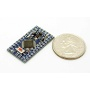

MLB712154134 - Arduino Pro Mini Atmega328p 16mhz 5v Nano Compatível
http://produto.mercadolivre.com.br/MLB-712154134-arduino-pro-mini-atmega328p-16mhz-5v-nano-compativel-_JM
564 unidades vendidas.
Faturamento de R$ 7614.0.



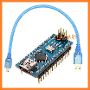

MLB723811978 - Arduino Atmega328 Nano 3.0v Rev3 Cabo Usb Robotica Automação
http://produto.mercadolivre.com.br/MLB-723811978-arduino-atmega328-nano-30v-rev3-cabo-usb-robotica-automaco-_JM
489 unidades vendidas.
Faturamento de R$ 12665.1.



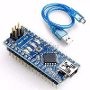

MLB740276709 - Arduino Nano V3.0 + Cabo Usb Atmega328 + Códigos De Exemplo
http://produto.mercadolivre.com.br/MLB-740276709-arduino-nano-v30-cabo-usb-atmega328-codigos-de-exemplo-_JM
327 unidades vendidas.
Faturamento de R$ 10627.5.



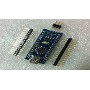

MLB710239737 - Arduino Nano - Controlador Nano 3.0
http://produto.mercadolivre.com.br/MLB-710239737-arduino-nano-controlador-nano-30-_JM
306 unidades vendidas.
Faturamento de R$ 6426.0.



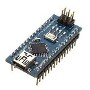

MLB705779338 - Arduino Nano V3
http://produto.mercadolivre.com.br/MLB-705779338-arduino-nano-v3-_JM
284 unidades vendidas.
Faturamento de R$ 6603.0.



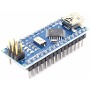

MLB713691061 - Arduino Nano V 3.0 Rev3 Atmega 328 5v 16mhz - Pronta Entrega
http://produto.mercadolivre.com.br/MLB-713691061-arduino-nano-v-30-rev3-atmega-328-5v-16mhz-pronta-entrega-_JM
257 unidades vendidas.
Faturamento de R$ 5137.43.



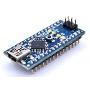

MLB714752789 - Arduino Nano V3.0 V3 Atmega328p Ch340g - Sem Cabo Usb
http://produto.mercadolivre.com.br/MLB-714752789-arduino-nano-v30-v3-atmega328p-ch340g-sem-cabo-usb-_JM
233 unidades vendidas.
Faturamento de R$ 3714.02.



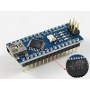

MLB680907035 - Arduino Nano V3.0 Com Cabo Usb
http://produto.mercadolivre.com.br/MLB-680907035-arduino-nano-v30-com-cabo-usb-_JM
205 unidades vendidas.
Faturamento de R$ 5104.5.



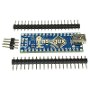

MLB691388441 - Arduino Nano 328 Sem Cabo Usb Sem Soldas Pronta Entrega
http://produto.mercadolivre.com.br/MLB-691388441-arduino-nano-328-sem-cabo-usb-sem-soldas-pronta-entrega-_JM
185 unidades vendidas.
Faturamento de R$ 4255.0.



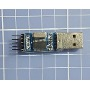

MLB683320470 - Conversor Usb Serial Rs232 Ttl Pl2303hx Arduino Mini Nano
http://produto.mercadolivre.com.br/MLB-683320470-conversor-usb-serial-rs232-ttl-pl2303hx-arduino-mini-nano-_JM
184 unidades vendidas.
Faturamento de R$ 2005.6.



In [7]:
# prints URLs from itens in chart

print('Os ' + str(ITEMS_TO_PLOT) + ' itens mais vendidos:', '\n')
for index, row in df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail']))
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print(str(df.loc[index, 'sold_quantity']) + ' unidades vendidas.')
    print('Faturamento de R$ ' + str(df.loc[index, 'revenue']) + '.')
    print()

## Itens mais vendidos e seus preços

Total de unidades vendidas ("arduino nano") = 5492


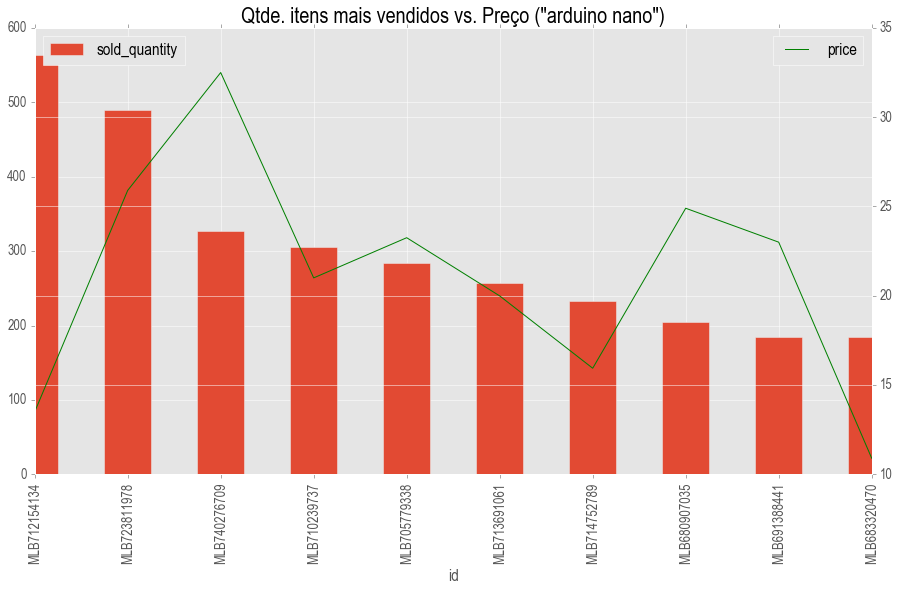

In [8]:
# sold quantity vs. unit price

print('Total de unidades vendidas ("' + query + '") = ' + str(total_sold_quantity))

# procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df.head(ITEMS_TO_PLOT).sold_quantity.plot(kind='bar', ax=ax0)#, label='Itens vendidos')
y1 = df.head(ITEMS_TO_PLOT).price.plot(secondary_y=True, style='g', ax=ax1)#, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Qtde. itens mais vendidos vs. Preço ("' + query + '")', fontsize=22)
plt.show()
plt.close()

## Faturamento por item

O faturamento total ("arduino nano") = R$ 146453.88


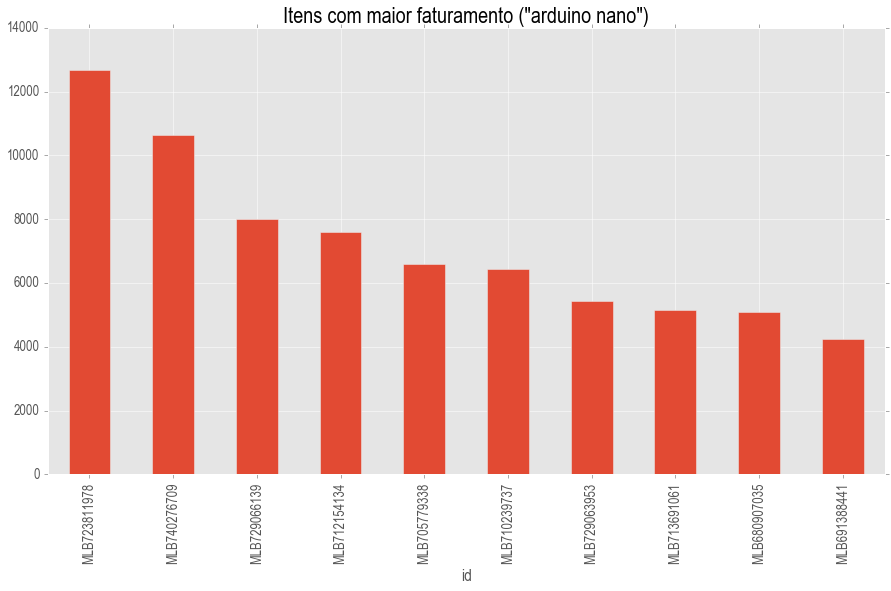

In [9]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))
df['revenue'].sort_values(ascending=False).head(ITEMS_TO_PLOT).plot(kind='bar')
plt.title('Itens com maior faturamento ("' + query + '")', fontsize=22)

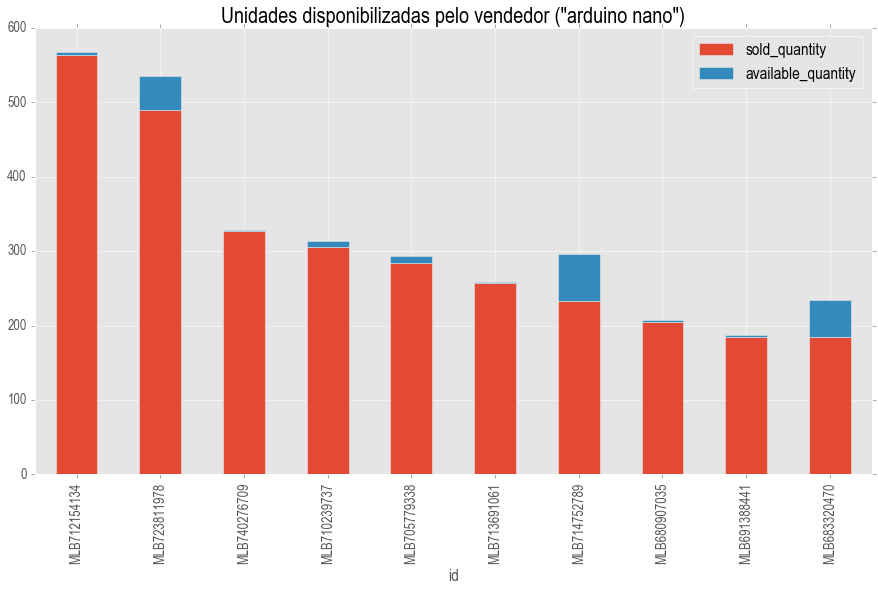

In [10]:
# total amount of each item (sold + stock)

df[['sold_quantity', 'available_quantity']].head(ITEMS_TO_PLOT).plot(kind='bar', stacked=True)
plt.title('Unidades disponibilizadas pelo vendedor ("' + query + '")', fontsize=22)

## Análise por cidade e estado (qtde. de anúncios e faturamento)

In [11]:
# location and stuff...

df2 = df # creates copy to play with

# extracting info from json/dict objects in cells

cities = [] # empty list to hold city names
states = [] # empty list to hold state names
sellers =[] # empty list to hold sellers ids

for index, row in df2.iterrows():
    cities.append(row['seller_address']['city']['name'])    
    states.append(row['seller_address']['state']['name'])    
    sellers.append(row['seller']['id'])    

df2['city'] = cities
df2['state'] = states
df2['seller_id'] = sellers
df2.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago,city,state,seller_id
id,,,,,,,,,,,,,,,
MLB712154134,Arduino Pro Mini Atmega328p 16mhz 5v Nano Comp...,13.50,564,4,http://produto.mercadolivre.com.br/MLB-7121541...,http://mlb-s1-p.mlstatic.com/14077-MLB40225374...,"{'latitude': -23.1831957, 'longitude': -47.287...","{'power_seller_status': 'silver', 'car_dealer'...",2035-10-04 16:22:12,7614.0,2015-10-04 16:22:12,399,Salto,São Paulo,39223635
MLB723811978,Arduino Atmega328 Nano 3.0v Rev3 Cabo Usb Robo...,25.90,489,46,http://produto.mercadolivre.com.br/MLB-7238119...,http://mlb-s2-p.mlstatic.com/356111-MLB2049475...,"{'latitude': -30.0575594, 'longitude': -51.172...","{'power_seller_status': 'platinum', 'car_deale...",2036-10-31 03:51:26,12665.1,2016-10-31 03:51:26,7,Porto Alegre,Rio Grande do Sul,128303656
MLB740276709,Arduino Nano V3.0 + Cabo Usb Atmega328 + Códig...,32.50,327,2,http://produto.mercadolivre.com.br/MLB-7402767...,http://mlb-s2-p.mlstatic.com/321611-MLB2057624...,"{'latitude': -23.9489829, 'longitude': -46.340...","{'power_seller_status': None, 'car_dealer': Fa...",2036-01-31 17:50:10,10627.5,2016-01-31 17:50:10,280,Santos,São Paulo,97979323
MLB710239737,Arduino Nano - Controlador Nano 3.0,21.00,306,8,http://produto.mercadolivre.com.br/MLB-7102397...,http://mlb-s1-p.mlstatic.com/553601-MLB2035948...,"{'latitude': -23.0886774, 'longitude': -47.208...","{'power_seller_status': None, 'car_dealer': Fa...",2035-09-28 01:33:10,6426.0,2015-09-28 01:33:10,406,Indaiatuba,São Paulo,102080085
MLB705779338,Arduino Nano V3,23.25,284,10,http://produto.mercadolivre.com.br/MLB-7057793...,http://mlb-s2-p.mlstatic.com/464401-MLB2033799...,"{'latitude': -18.9142217, 'longitude': -48.257...","{'power_seller_status': 'gold', 'car_dealer': ...",2035-09-14 02:21:07,6603.0,2015-09-14 02:21:07,420,Uberlândia,Minas Gerais,74184676


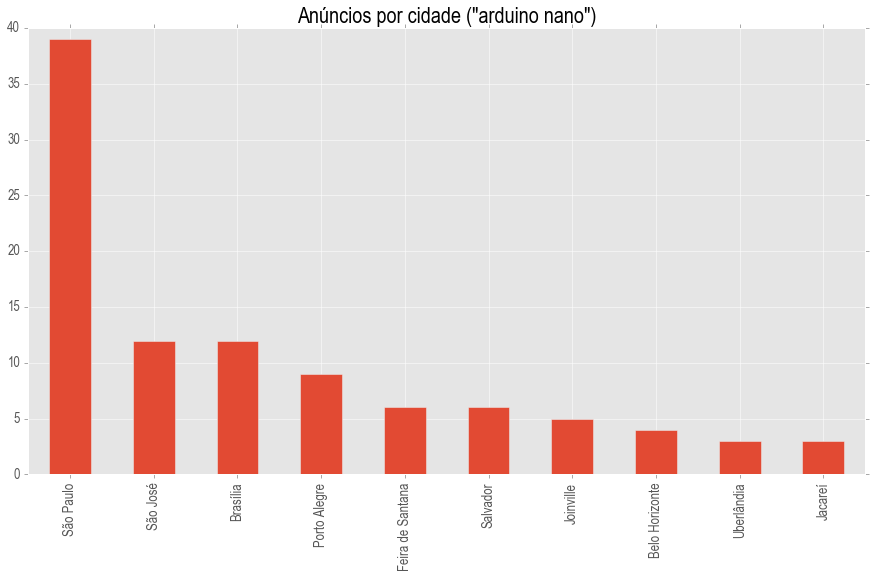

In [12]:
# plots itens by cities

df2.city.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por cidade ("' + query + '")', fontsize=22)

O faturamento total ("arduino nano") = R$ 146453.88


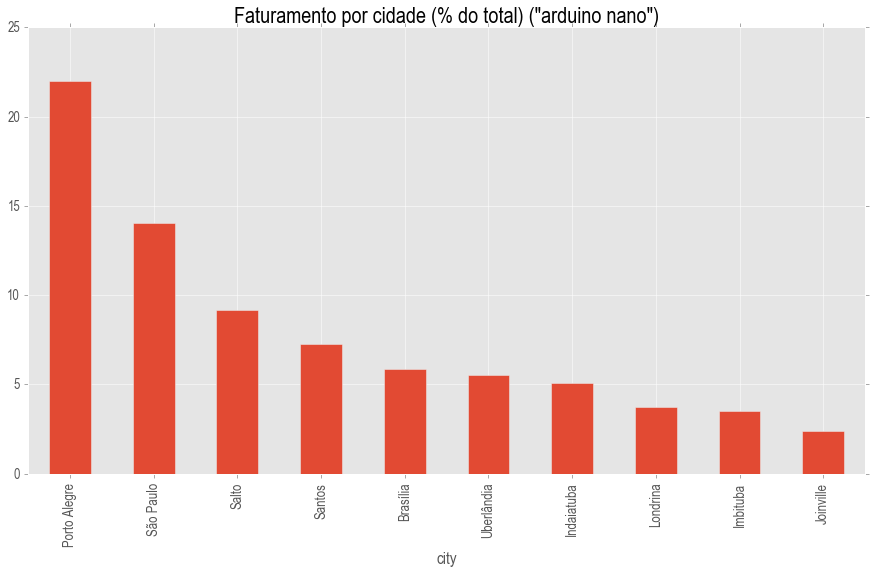

In [13]:
# revenue per city
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_city = (df2.groupby('city').sum().revenue / total_revenue) * 100 # aggregates data by city, sums by revenue and gets proportion from total
revenue_share_by_city.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Faturamento por cidade (% do total) ("' + query + '")', fontsize=22)

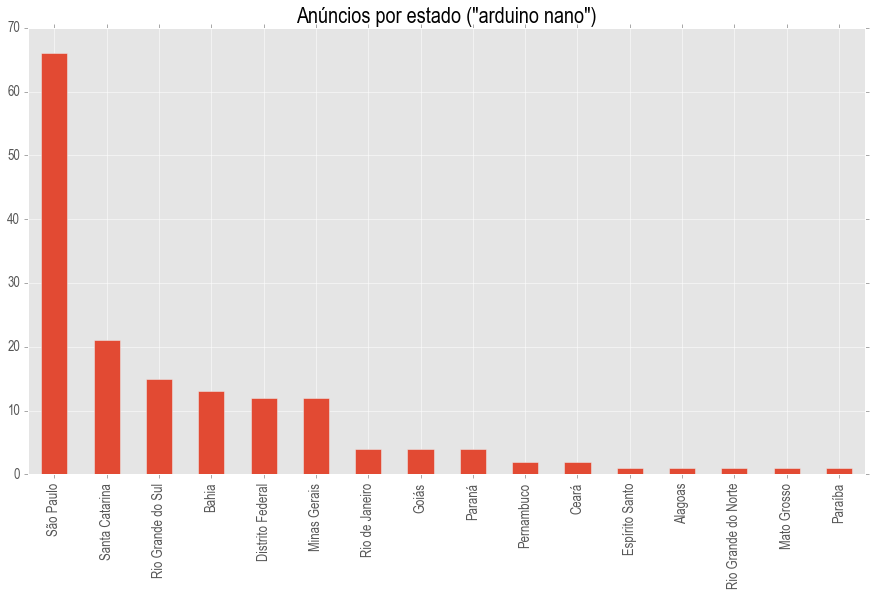

In [14]:
# plots itens by states
df2.state.value_counts().plot(kind='bar')
plt.title('Anúncios por estado ("' + query + '")', fontsize=22)

O faturamento total ("arduino nano") = R$ 146453.88


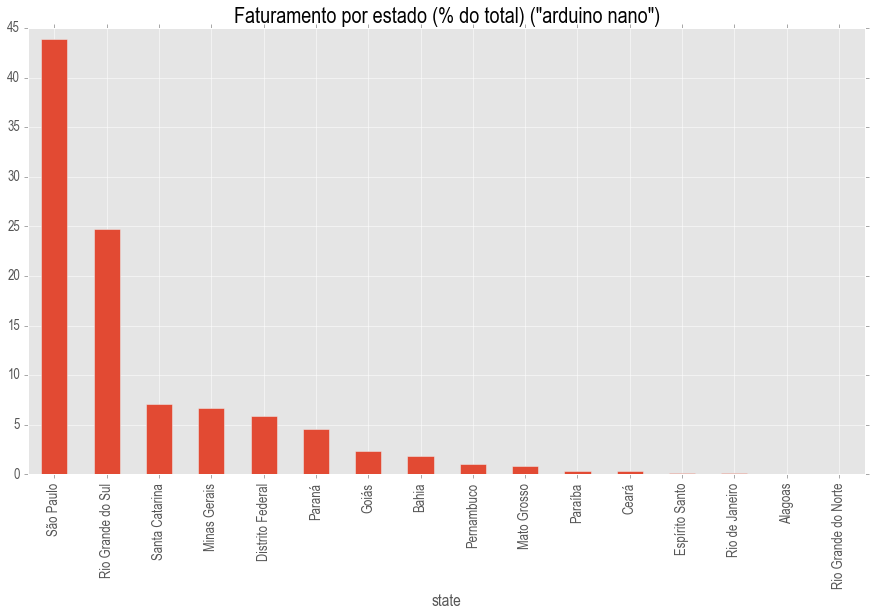

In [15]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_state = (df2.groupby('state').sum().revenue / total_revenue) * 100
revenue_share_by_state.sort_values(ascending=False).plot(kind='bar')
plt.title('Faturamento por estado (% do total) ("' + query + '")', fontsize=22)

## Análise por vendedores

In [16]:
sellers_df = df2.groupby('seller_id').sum() # aggregates by sellers id, summing up the columns
sellers_df.price = df2.groupby('seller_id').mean().price # substitutes sum of prices by mean price by seller
sellers_df = sellers_df.rename(columns={'price': 'average_price'})
sellers_df.sort_values('revenue', ascending=False).head()

,average_price,sold_quantity,available_quantity,revenue,days_ago
seller_id,,,,,
128303656,355.485714,891,257,32128.90,625
39223635,52.800000,691,8,13399.40,1229
82246014,55.411538,354,79,11807.57,4213
97979323,32.500000,327,2,10627.50,280
102080085,28.000000,336,12,7476.00,802


O faturamento total ("arduino nano") = R$ 146453.88


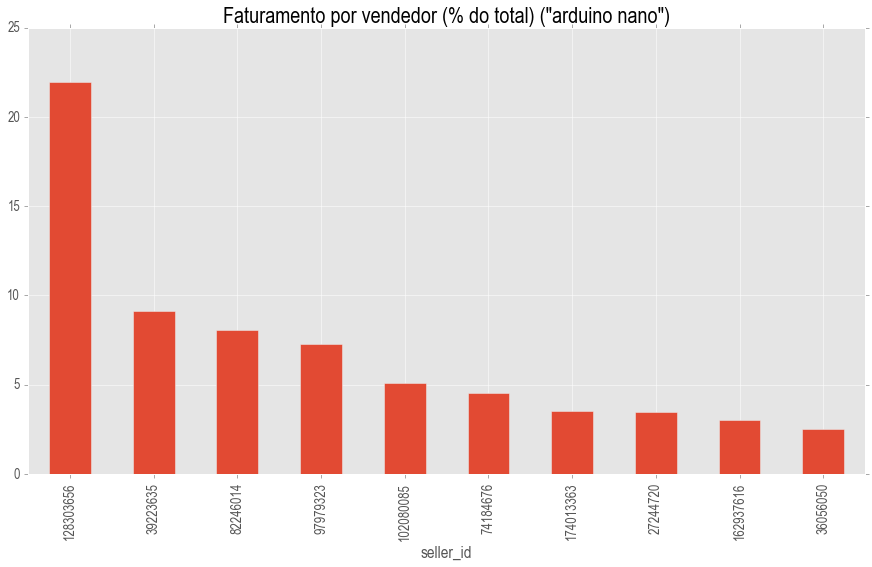

In [17]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

sellers_df = sellers_df.sort_values('revenue', ascending=False)
#sellers_df.revenue.sort_values(ascending=False).head(20).plot(kind='bar')

revenue_share_by_seller = (sellers_df['revenue'] / total_revenue) * 100
revenue_share_by_seller.head(10).plot(kind='bar')
plt.title('Faturamento por vendedor (% do total) ("' + query + '")', fontsize=22)
#sellers_df.head()

### Vendedor e itens como índices
Verificar como operar e se é útil de alguma forma...

In [18]:
# groups sellers and items, and then ...?
s = df2.reset_index()
s = s.groupby(['seller_id', 'id', 'permalink']).sum() # aggregates data by id and permalink to "save" them from being hidden

# sets id and permalink to be data in df
s = s.reset_index('id')
s = s.reset_index('permalink')

#reorder columns to make it readable
s = s[['id', 'sold_quantity', 'price', 'revenue', 'available_quantity', 'permalink']] 

s.head(10)

,id,sold_quantity,price,revenue,available_quantity,permalink
seller_id,,,,,,
1382520,MLB796185448,0,47.00,0.0,1,http://produto.mercadolivre.com.br/MLB-7961854...
2220415,MLB773104192,2,21.90,43.8,3,http://produto.mercadolivre.com.br/MLB-7731041...
3704222,MLB711777829,101,28.00,2828.0,25,http://produto.mercadolivre.com.br/MLB-7117778...
3704222,MLB793191527,0,15.00,0.0,25,http://produto.mercadolivre.com.br/MLB-7931915...
4627643,MLB751428763,0,35.66,0.0,1,http://produto.mercadolivre.com.br/MLB-7514287...
6174036,MLB706931545,3,30.00,90.0,3,http://produto.mercadolivre.com.br/MLB-7069315...
6174036,MLB712763517,0,20.00,0.0,10,http://produto.mercadolivre.com.br/MLB-7127635...
11568086,MLB687013554,3,29.90,89.7,2,http://produto.mercadolivre.com.br/MLB-6870135...
11568086,MLB706858415,5,40.00,200.0,1,http://produto.mercadolivre.com.br/MLB-7068584...


## Análise da data de anúncio dos itens (recenticidade)

In [19]:
# plot by days_ago (by date as the following charts is nicer)
#_range = (0, 30)
#df.days_ago.hist(range=_range, bins=30)
#plt.title('Distribuição de itens adicionados nos últimos 30 dias (dias atrás) ("' + query + '")', fontsize=22)

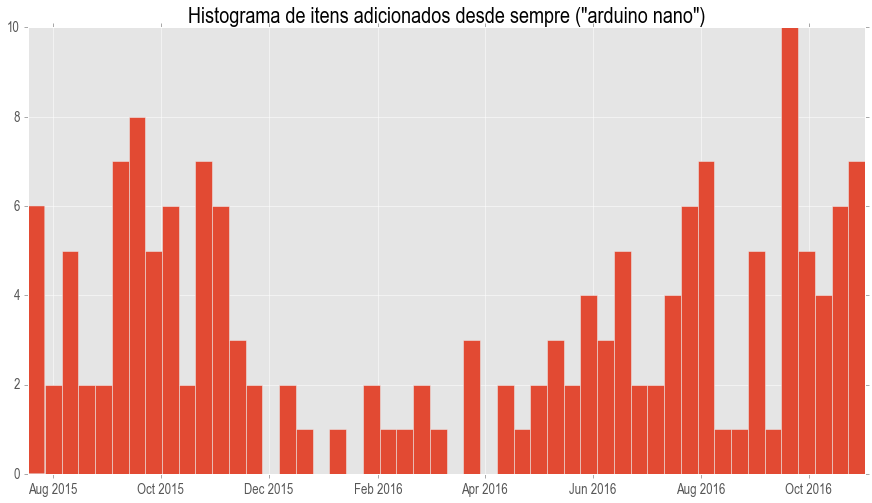

In [20]:
s = df

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados desde sempre ("' + query + '")', fontsize=22)

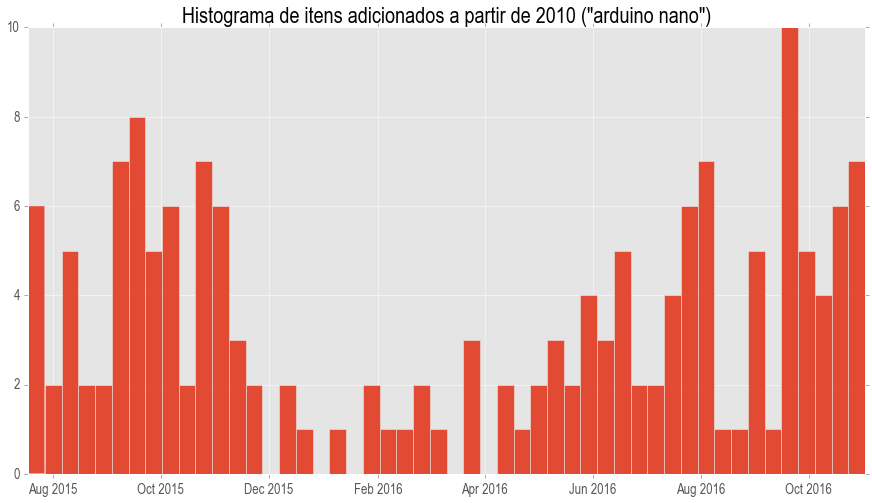

In [21]:
s = df[(df.start_time > '2010-01-01')] # filter dates later than 2010

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2010 ("' + query + '")', fontsize=22)

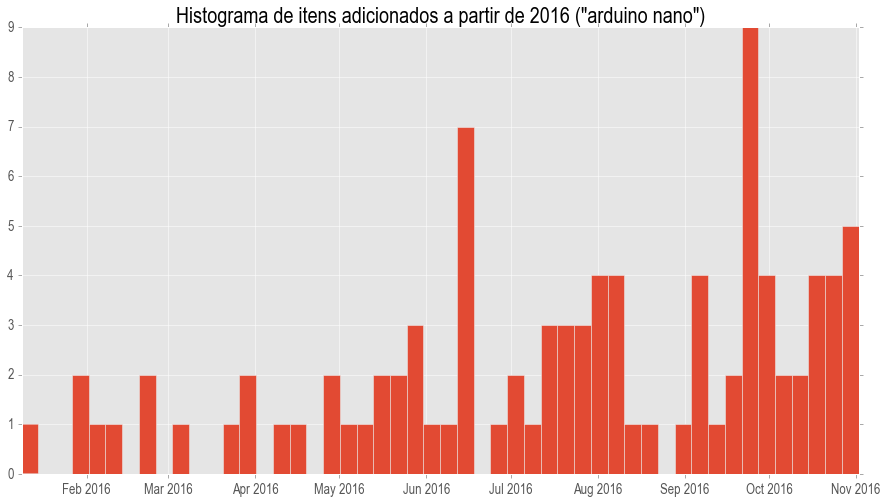

In [22]:
s = df[(df.start_time > '2016-01-01')] # filter dates later than 2016

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2016 ("' + query + '")', fontsize=22)

Os 10 itens mais recentes: 



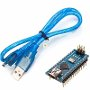

MLB810177910 - Arduino Nano V3 Atmega328p Ch340g + Cabo Usb - Garantia
http://produto.mercadolivre.com.br/MLB-810177910-arduino-nano-v3-atmega328p-ch340g-cabo-usb-garantia-_JM
Adicionado há 5 dias.
0 unidade(s) já vendida(s).



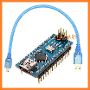

MLB723811978 - Arduino Atmega328 Nano 3.0v Rev3 Cabo Usb Robotica Automação
http://produto.mercadolivre.com.br/MLB-723811978-arduino-atmega328-nano-30v-rev3-cabo-usb-robotica-automaco-_JM
Adicionado há 7 dias.
489 unidade(s) já vendida(s).



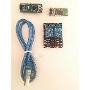

MLB710548533 - Arduino Nano Bluetooth Rele 5v 2 Canais Automação -
http://produto.mercadolivre.com.br/MLB-710548533-arduino-nano-bluetooth-rele-5v-2-canais-automaco--_JM
Adicionado há 7 dias.
5 unidade(s) já vendida(s).



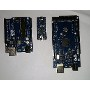

MLB701244535 - Arduino Mega 2560 - Uno R3 - Nano 3.0
http://produto.mercadolivre.com.br/MLB-701244535-arduino-mega-2560-uno-r3-nano-30-_JM
Adicionado há 7 dias.
6 unidade(s) já vendida(s).



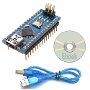

MLB714242295 - Arduino Nano V3.0 Bom P/ Automação Robótica E Mecatrônica
http://produto.mercadolivre.com.br/MLB-714242295-arduino-nano-v30-bom-p-automaco-robotica-e-mecatrnica-_JM
Adicionado há 8 dias.
3 unidade(s) já vendida(s).



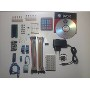

MLB808360008 - Kit Arduino Nano 3.0 + Dvd Com 50 Projetos
http://produto.mercadolivre.com.br/MLB-808360008-kit-arduino-nano-30-dvd-com-50-projetos-_JM
Adicionado há 12 dias.
0 unidade(s) já vendida(s).



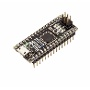

MLB808101359 - Nano Ch340g Atmega328p Microusb Compatível Nano V3 Arduino
http://produto.mercadolivre.com.br/MLB-808101359-nano-ch340g-atmega328p-microusb-compativel-nano-v3-arduino-_JM
Adicionado há 13 dias.
0 unidade(s) já vendida(s).



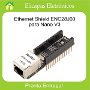

MLB807590664 - Shield Ethernet Enc28j60 + Arduino Nano V3.0 Ch340 Usb Drive
http://produto.mercadolivre.com.br/MLB-807590664-shield-ethernet-enc28j60-arduino-nano-v30-ch340-usb-drive-_JM
Adicionado há 15 dias.
0 unidade(s) já vendida(s).



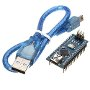

MLB751428763 - Arduino Nano V3.0 + Cabo + Slot Microsd Card
http://produto.mercadolivre.com.br/MLB-751428763-arduino-nano-v30-cabo-slot-microsd-card-_JM
Adicionado há 15 dias.
0 unidade(s) já vendida(s).



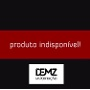

MLB807014888 - Arduino Nano V3.0 Atmega 328p Micro Usb Black Compatível
http://produto.mercadolivre.com.br/MLB-807014888-arduino-nano-v30-atmega-328p-micro-usb-black-compativel-_JM
Adicionado há 17 dias.
1 unidade(s) já vendida(s).



In [23]:
print('Os ' + str(ITEMS_TO_PLOT) + ' itens mais recentes:', '\n')

recent_itens_df = df.sort_values('days_ago', ascending=True)

for index, row in recent_itens_df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail'])) 
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print(str(df.loc[index, 'sold_quantity']) + ' unidade(s) já vendida(s).')
    print()

    

---
## Request por visitas dos itens filtrados e ordenados

- Itens mais vendidos
- Itens mais recentes

### Função para gerar DataFrame de visitas

In [24]:
def get_visits_df(days, ids):
    
    ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

    url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
    data = requests.get(url).json()

    visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
    visits_df = visits_df[['date', 'total']] # gets only main columns
    visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

    column_headers = [] # list to store item ids used as column headers
    column_headers.append(data[0]['item_id'])

    # iterates over data items to merge all 'total' columns into same df
    for item in data[1:]:
        results = item['results']
        df_temp = DataFrame(results)
        df_temp = df_temp[['date', 'total']]
        df_temp.columns = ['date', item['item_id']]
        column_headers.append(item['item_id'])
        visits_df = pd.merge(visits_df, df_temp, on='date')

    #print(column_headers)
    #visits_df.head()

    # fixes df, parsing 'date' properly and setting as index column
    visits_df['date'] = pd.to_datetime(visits_df['date'])
    visits_df = visits_df.set_index('date')

    #visits_df.head()
    return visits_df

### Visitas aos itens mais vendidos

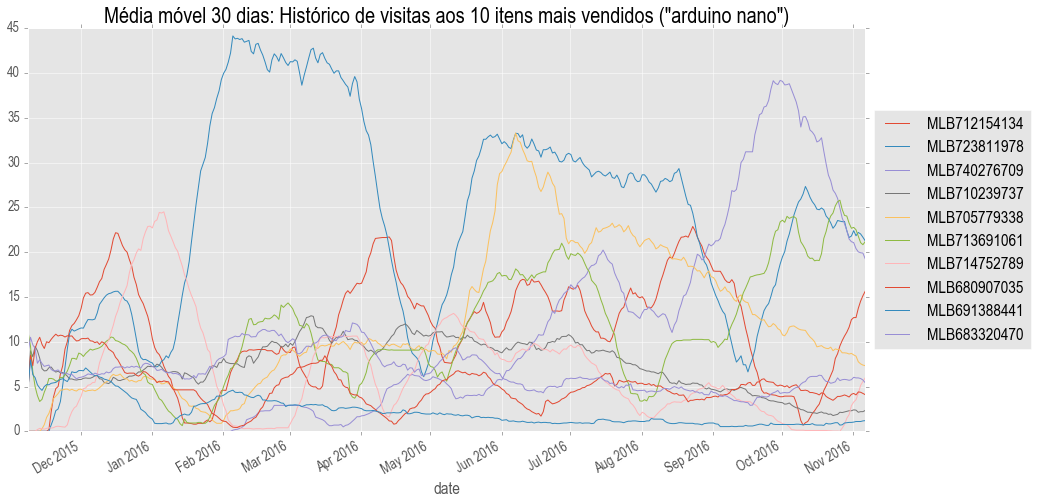

In [25]:
# defines ids from top sold itens
top_sold_ids = df.sort_values('sold_quantity', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_sold_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais vendidos ("' + query + '")', fontsize=22)

most_sold_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais recentes

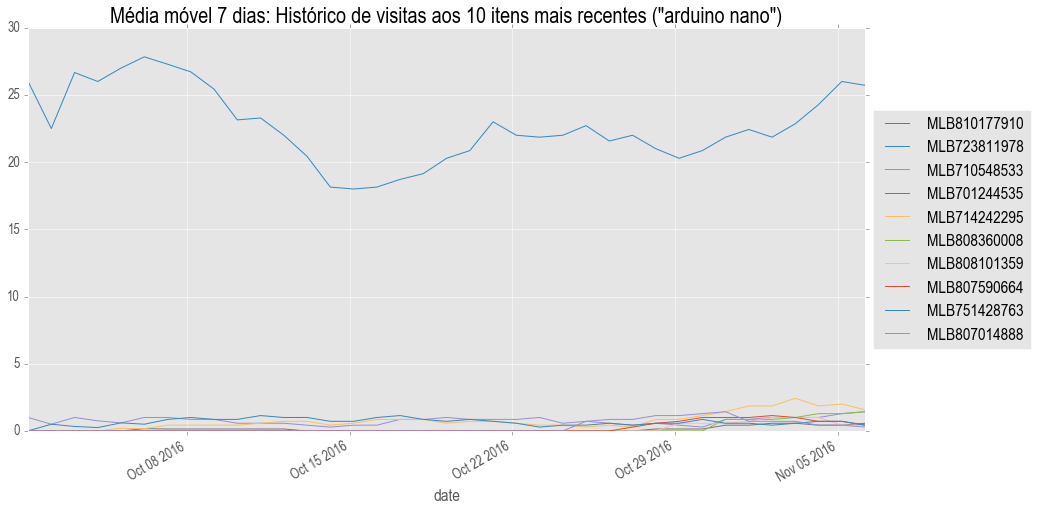

In [29]:
# gets ids from most recent itens
recent_ids = recent_itens_df.index.values[0:ITEMS_TO_PLOT] # gets most recent items ML ids in a list

# get df by calling function with most recent ids
visits_df = get_visits_df(DAYS_AGO, recent_ids)
visits_df = visits_df['2016-10-01':] # filters by some date (e.g. 1st of january, 2016)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 7;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais recentes ("' + query + '")', fontsize=22)

most_recent_visits_df = visits_df # saves to a uniquely named df to be exported later

In [27]:
# normal plot
#plt.figure()
#visits_df.plot(legend=True);
#plt.title('Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

# cumulative sum plot
#cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
#plt.figure();
#cumulative_visits_df.plot(legend=True);
#plt.title('Soma acumulada: Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

## Exporta dados para Excel
Salva os principais DataFrames em diferentes abas de um arquivo .xlsx e salva na pasta raiz.

In [28]:
# saves main df to Excel format
today_str = today.strftime('%Y-%m-%d_%H%M') # makes string with today's date

writer = pd.ExcelWriter(today_str + '_' + query + '.xlsx')

df.to_excel(writer, 'main_data')
sellers_df.to_excel(writer, 'sellers')
most_sold_visits_df.to_excel(writer, 'visits-most_sold')
most_recent_visits_df.to_excel(writer, 'visits-most_recent')

writer.save()
writer.close()

## Todo:
**Features**
- Plot itens by seller location (map?)
- <s>Calculate revenue per seller (extract from seller dict in raw df)</s>
- <s>Understand data aggregated by SELLER, not only by separate items</s>
- Get location of the BUYERS, not only sellers
- Compare seller revenue with its ratings/feedbacks
- <s>Analyse itens by date and recently added itens</s>
- <s>Play around with 'added_days_ago' and 'sold_quantity' = how appealing the product is</s>
- Filter by minimum item price
---
**Code improvement**
- Fix query handling for 0 results
- Fix query handling for null query as input
- Fix documentation/description
- Make dates relative to today's (e.g. instead of '2016', get the year from datetime 'today')
---
**Usability**
- Add an index for jumping to parts (links for navigation)

## Todo (for version as a service):
- Compare sellers' itens with competitors: "how I am performing?"